In [28]:
import matplotlib.pyplot as plt
import numpy as np

import matplotlib.pyplot as plt
import numpy as np

def plot_hammering_grid(hammering_pattern, address_mapping, title):
    # Map access ID → row address
    id_to_row = {aid: mapping["row"] for aid, mapping in address_mapping["aggressor_to_addr"]}
    
    access_ids = hammering_pattern["access_ids"]
    rows = [id_to_row.get(aid, -1) for aid in access_ids]
    
    # Filter out unmapped IDs
    valid_indices = [i for i, r in enumerate(rows) if r != -1]
    rows = [rows[i] for i in valid_indices]

    # Normalize rows to a compact index space for plotting
    unique_rows = sorted(set(rows))
    row_to_idx = {row: i for i, row in enumerate(unique_rows)}
    row_indices = [row_to_idx[r] for r in rows]
    
    # Create a binary matrix (row × time)
    time_steps = len(row_indices)
    height = len(unique_rows)
    grid = np.zeros((height, time_steps), dtype=int)
    
    for t, row in enumerate(row_indices):
        grid[row, t] = 1
    
    # Plot grid
    plt.figure(figsize=(15, 6))
    plt.imshow(grid, aspect='auto', cmap='Greys', interpolation='none', origin='lower')
    plt.xlabel("Access Index (Time)")
    plt.ylabel("Row Index")
    plt.title(title)
    step = max(1, len(unique_rows) // 20)  # Show ~20 labels or fewer
    tick_indices = np.arange(0, len(unique_rows), step)
    tick_labels = [unique_rows[i] for i in tick_indices]
    plt.yticks(ticks=tick_indices, labels=tick_labels)   
    plt.colorbar(label='Accessed')
    plt.tight_layout()
    plt.show()



In [29]:
def generate_tikz_with_axes(hammering_pattern, address_mapping, max_height=40, x_tick_step=50):
    id_to_row = {aid: mapping["row"] for aid, mapping in address_mapping["aggressor_to_addr"]}
    access_ids = hammering_pattern["access_ids"]
    rows = [id_to_row.get(aid, -1) for aid in access_ids if aid in id_to_row]

    # Normalize and downsample Y (row)
    unique_rows = sorted(set(rows))
    if len(unique_rows) > max_height:
        step = max(1, len(unique_rows) // max_height)
        unique_rows = unique_rows[::step]
    row_to_idx = {r: i for i, r in enumerate(unique_rows)}

    height = len(unique_rows)
    width = len(access_ids)

    tikz = [
        "\\begin{tikzpicture}[x=0.05cm,y=0.25cm]",
        "  \\draw[step=1,gray,very thin] (0,0) grid (%d,%d);" % (width, height),
        "  \\draw[->,thick] (0,0) -- (%d,0) node[right] {\\small Access Index (Time)};" % width,
        "  \\draw[->,thick] (0,0) -- (0,%d) node[above] {\\small Row Address};" % height,
    ]

    # Draw filled accesses
    for t, aid in enumerate(access_ids):
        row = id_to_row.get(aid)
        if row in row_to_idx:
            y = row_to_idx[row]
            tikz.append(f"  \\fill[black] ({t}, {y}) rectangle ({t+1}, {y+1});")

    # X-axis ticks
    for x in range(0, width+1, x_tick_step):
        tikz.append(f"  \\draw[thick] ({x},0) -- ({x},-0.5) node[below] {{\\tiny {x}}};")

    # Y-axis ticks (every 5 rows or so)
    y_step = max(1, height // 10)
    for i in range(0, height, y_step):
        label = unique_rows[i]
        tikz.append(f"  \\draw[thick] (0,{i}) -- (-0.5,{i}) node[left] {{\\tiny {label}}};")

    tikz.append("\\end{tikzpicture}")
    return "\n".join(tikz)


In [30]:
def generate_pgfplots_scatter(hammering_pattern, address_mapping, max_height=40, y_tick_count=10, x_tick_step=50):
    id_to_row = {aid: mapping["row"] for aid, mapping in address_mapping["aggressor_to_addr"]}
    access_ids = hammering_pattern["access_ids"]
    rows = [id_to_row.get(aid, -1) for aid in access_ids if aid in id_to_row]

    # Normalize Y-axis (row) to index space
    unique_rows = sorted(set(rows))
    if len(unique_rows) > max_height:
        step = max(1, len(unique_rows) // max_height)
        unique_rows = unique_rows[::step]
    row_to_idx = {r: i for i, r in enumerate(unique_rows)}

    # Data points
    pgf_data = []
    for t, aid in enumerate(access_ids):
        row = id_to_row.get(aid)
        if row in row_to_idx:
            y = row_to_idx[row]
            pgf_data.append(f"{t} {y}")

    width = len(access_ids)
    height = len(unique_rows)

    # Y tick labels
    y_ticks = list(range(0, height, max(1, height // y_tick_count)))
    y_labels = [str(unique_rows[i]) for i in y_ticks]

    # Assemble TikZ with pgfplots scatter
    tikz_code = [
        "\\begin{tikzpicture}",
        "  \\begin{axis}[",
        "    xlabel={Access Index (Time)}, ylabel={Row Address},",
        "    tick label style={font=\\tiny},",
        "    label style={font=\\small},",
        "    width=\\textwidth, height=6cm,",
        "    xtick distance=%d," % x_tick_step,
        "    ytick={" + ",".join(str(i) for i in y_ticks) + "},",
        "    yticklabels={" + ",".join(y_labels) + "},",
        "    y dir=reverse,",
        "    grid=both,",
        "    scatter/use mapped color={draw=black,fill=black},",
        "    only marks, mark=square*, mark size=1.5pt,",
        "  ]",
        "    \\addplot table [x index=0, y index=1] {%",
    ] + pgf_data + [
        "    };",
        "  \\end{axis}",
        "\\end{tikzpicture}"
    ]

    return "\n".join(tikz_code)


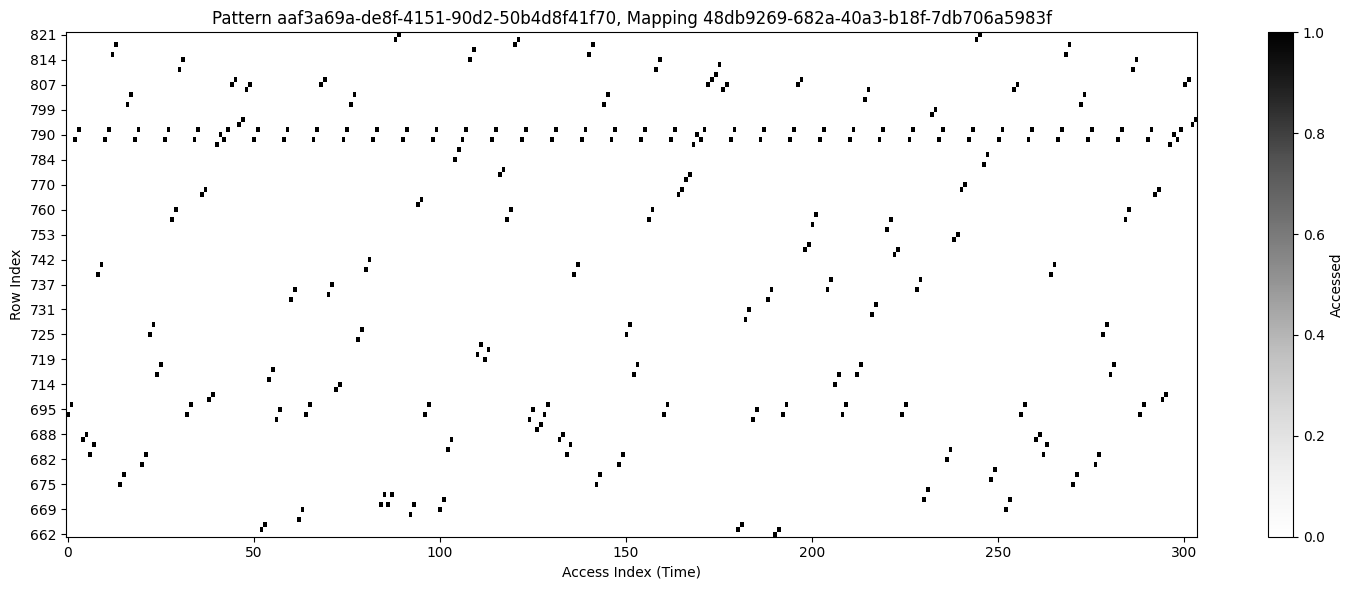

\begin{tikzpicture}
  \begin{axis}[
    xlabel={Access Index (Time)}, ylabel={Row Address},
    tick label style={font=\tiny},
    label style={font=\small},
    width=\textwidth, height=6cm,
    xtick distance=50,
    ytick={0,5,10,15,20,25,30,35,40,45,50},
    yticklabels={662,675,688,714,725,737,753,770,790,807,821},
    y dir=reverse,
    grid=both,
    scatter/use mapped color={draw=black,fill=black},
    only marks, mark=square*, mark size=1.5pt,
  ]
    \addplot table [x index=0, y index=1] {%
0 12
1 13
5 10
6 8
7 9
8 26
9 27
12 48
13 49
14 5
15 6
16 43
17 44
20 7
21 8
22 20
23 21
24 16
25 17
32 12
33 13
36 34
39 14
40 39
41 40
44 45
46 41
49 45
53 1
64 12
65 13
68 45
70 24
71 25
73 15
76 43
77 44
84 3
85 4
86 3
87 4
89 50
92 2
93 3
94 33
96 12
97 13
110 18
111 19
116 36
120 49
127 11
128 12
129 13
133 10
134 8
135 9
136 26
137 27
140 48
141 49
142 5
143 6
144 43
145 44
148 7
149 8
150 20
151 21
152 16
153 17
160 12
161 13
164 34
167 36
168 39
169 40
172 45
174 46
175 47
177 45


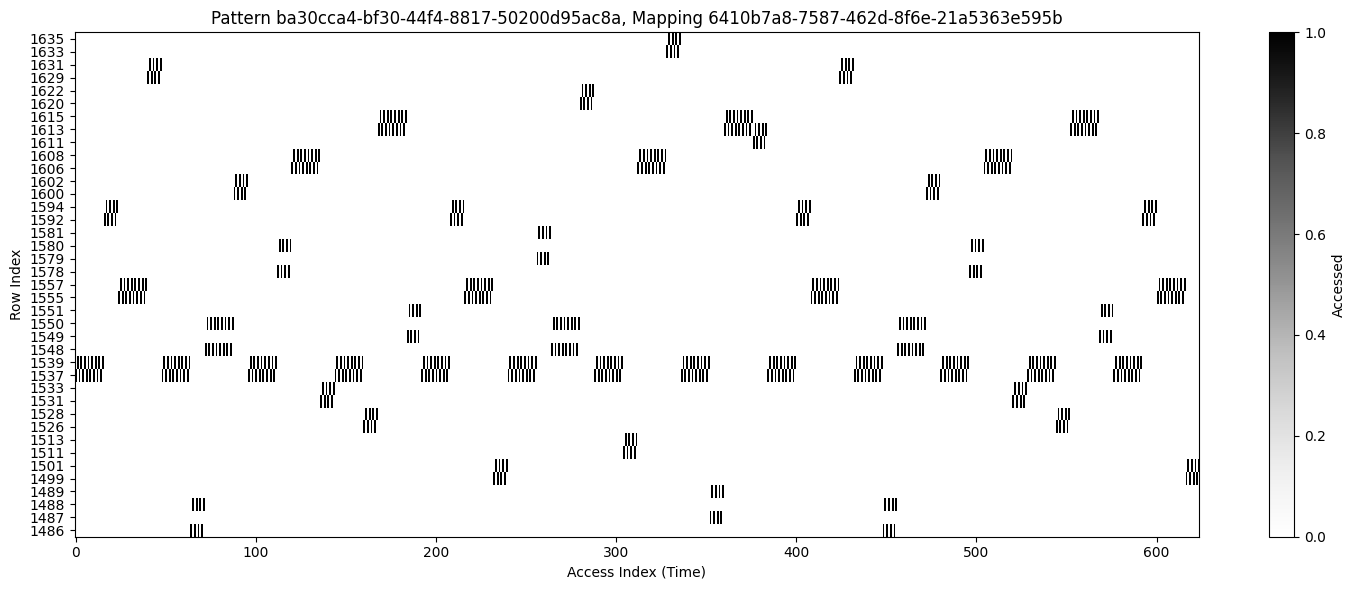

\begin{tikzpicture}
  \begin{axis}[
    xlabel={Access Index (Time)}, ylabel={Row Address},
    tick label style={font=\tiny},
    label style={font=\small},
    width=\textwidth, height=6cm,
    xtick distance=50,
    ytick={0,3,6,9,12,15,18,21,24,27,30,33,36},
    yticklabels={1486,1489,1511,1528,1537,1549,1555,1579,1592,1602,1611,1620,1631},
    y dir=reverse,
    grid=both,
    scatter/use mapped color={draw=black,fill=black},
    only marks, mark=square*, mark size=1.5pt,
  ]
    \addplot table [x index=0, y index=1] {%
0 12
1 13
2 12
3 13
4 12
5 13
6 12
7 13
8 12
9 13
10 12
11 13
12 12
13 13
14 12
15 13
16 24
17 25
18 24
19 25
20 24
21 25
22 24
23 25
24 18
25 19
26 18
27 19
28 18
29 19
30 18
31 19
32 18
33 19
34 18
35 19
36 18
37 19
38 18
39 19
40 35
41 36
42 35
43 36
44 35
45 36
46 35
47 36
48 12
49 13
50 12
51 13
52 12
53 13
54 12
55 13
56 12
57 13
58 12
59 13
60 12
61 13
62 12
63 13
64 0
65 2
66 0
67 2
68 0
69 2
70 0
71 2
72 14
73 16
74 14
75 16
76 14
77 16
78 14
79 16
80 14
8

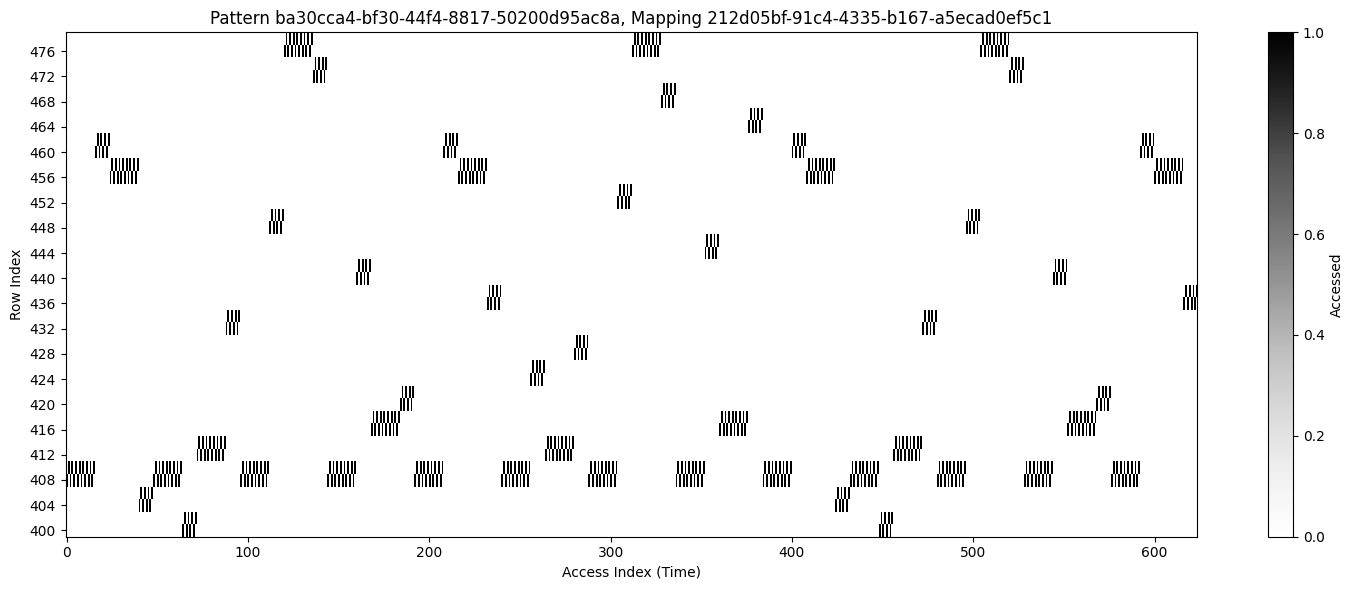

\begin{tikzpicture}
  \begin{axis}[
    xlabel={Access Index (Time)}, ylabel={Row Address},
    tick label style={font=\tiny},
    label style={font=\small},
    width=\textwidth, height=6cm,
    xtick distance=50,
    ytick={0,4,8,12,16,20,24,28,32,36},
    yticklabels={400,408,416,424,432,440,448,456,464,472},
    y dir=reverse,
    grid=both,
    scatter/use mapped color={draw=black,fill=black},
    only marks, mark=square*, mark size=1.5pt,
  ]
    \addplot table [x index=0, y index=1] {%
0 4
1 5
2 4
3 5
4 4
5 5
6 4
7 5
8 4
9 5
10 4
11 5
12 4
13 5
14 4
15 5
16 30
17 31
18 30
19 31
20 30
21 31
22 30
23 31
24 28
25 29
26 28
27 29
28 28
29 29
30 28
31 29
32 28
33 29
34 28
35 29
36 28
37 29
38 28
39 29
40 2
41 3
42 2
43 3
44 2
45 3
46 2
47 3
48 4
49 5
50 4
51 5
52 4
53 5
54 4
55 5
56 4
57 5
58 4
59 5
60 4
61 5
62 4
63 5
64 0
65 1
66 0
67 1
68 0
69 1
70 0
71 1
72 6
73 7
74 6
75 7
76 6
77 7
78 6
79 7
80 6
81 7
82 6
83 7
84 6
85 7
86 6
87 7
88 16
89 17
90 16
91 17
92 16
93 17
94 16
95 17


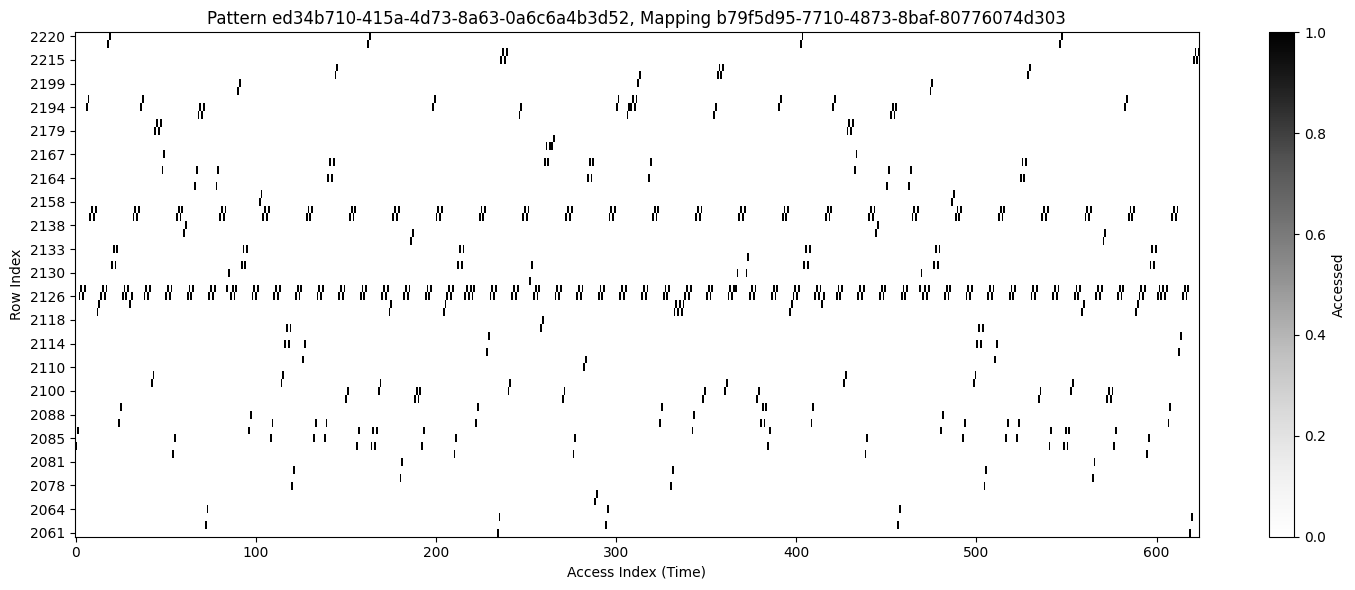

\begin{tikzpicture}
  \begin{axis}[
    xlabel={Access Index (Time)}, ylabel={Row Address},
    tick label style={font=\tiny},
    label style={font=\small},
    width=\textwidth, height=6cm,
    xtick distance=50,
    ytick={0,6,12,18,24,30,36,42,48,54,60},
    yticklabels={2061,2078,2085,2100,2114,2126,2133,2158,2167,2194,2215},
    y dir=reverse,
    grid=both,
    scatter/use mapped color={draw=black,fill=black},
    only marks, mark=square*, mark size=1.5pt,
  ]
    \addplot table [x index=0, y index=1] {%
0 11
1 13
2 30
3 31
4 30
5 31
6 54
7 55
8 40
9 41
10 40
11 41
12 28
13 29
14 30
15 31
16 30
17 31
18 62
19 63
20 34
21 36
22 34
23 36
24 14
25 16
26 30
27 31
28 30
29 31
30 29
31 30
32 40
33 41
34 40
35 41
36 54
37 55
38 30
39 31
40 30
41 31
42 19
43 20
44 51
45 52
46 51
47 52
48 46
49 48
50 30
51 31
52 30
53 31
54 10
55 12
56 40
57 41
58 40
59 41
60 38
61 39
62 30
63 31
64 30
65 31
66 44
67 46
68 53
69 54
70 53
71 54
72 1
73 3
74 30
75 31
76 30
77 31
78 44
79 46
80 40
81 41
82 

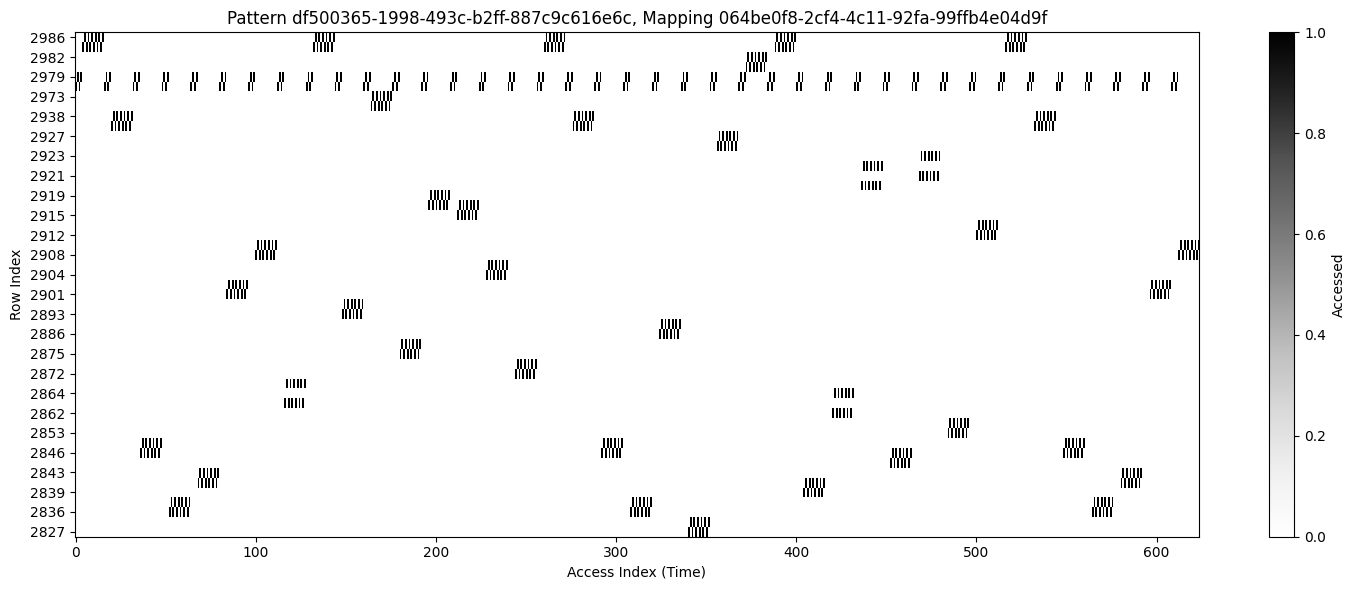

\begin{tikzpicture}
  \begin{axis}[
    xlabel={Access Index (Time)}, ylabel={Row Address},
    tick label style={font=\tiny},
    label style={font=\small},
    width=\textwidth, height=6cm,
    xtick distance=50,
    ytick={0,5,10,15,20,25,30,35,40,45,50},
    yticklabels={2827,2841,2853,2865,2886,2903,2912,2920,2927,2977,2986},
    y dir=reverse,
    grid=both,
    scatter/use mapped color={draw=black,fill=black},
    only marks, mark=square*, mark size=1.5pt,
  ]
    \addplot table [x index=0, y index=1] {%
0 45
1 46
2 45
3 46
4 49
5 50
6 49
7 50
8 49
9 50
10 49
11 50
12 49
13 50
14 49
15 50
16 45
17 46
18 45
19 46
20 41
21 42
22 41
23 42
24 41
25 42
26 41
27 42
28 41
29 42
30 41
31 42
32 45
33 46
34 45
35 46
36 8
37 9
38 8
39 9
40 8
41 9
42 8
43 9
44 8
45 9
46 8
47 9
48 45
49 46
50 45
51 46
52 2
53 3
54 2
55 3
56 2
57 3
58 2
59 3
60 2
61 3
62 2
63 3
64 45
65 46
66 45
67 46
68 5
69 6
70 5
71 6
72 5
73 6
74 5
75 6
76 5
77 6
78 5
79 6
80 45
81 46
82 45
83 46
84 24
85 25
86 24
87 25
8

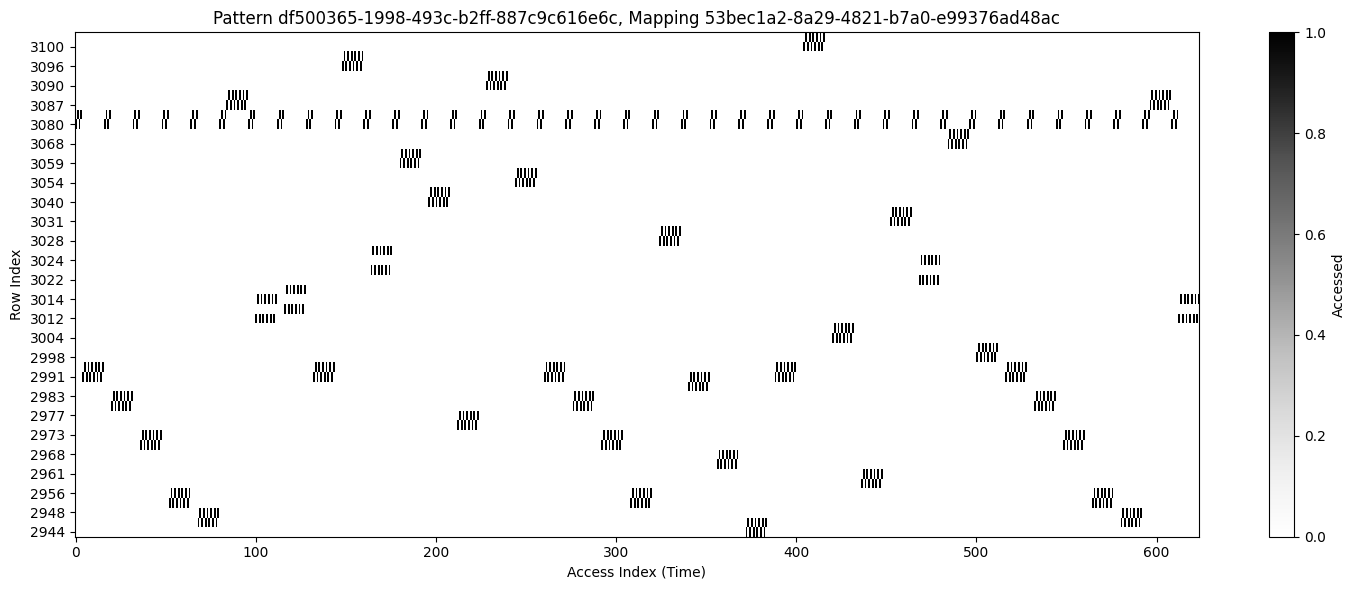

\begin{tikzpicture}
  \begin{axis}[
    xlabel={Access Index (Time)}, ylabel={Row Address},
    tick label style={font=\tiny},
    label style={font=\small},
    width=\textwidth, height=6cm,
    xtick distance=50,
    ytick={0,5,10,15,20,25,30,35,40,45,50},
    yticklabels={2944,2959,2973,2989,3004,3015,3028,3042,3068,3089,3100},
    y dir=reverse,
    grid=both,
    scatter/use mapped color={draw=black,fill=black},
    only marks, mark=square*, mark size=1.5pt,
  ]
    \addplot table [x index=0, y index=1] {%
0 42
1 43
2 42
3 43
4 16
5 17
6 16
7 17
8 16
9 17
10 16
11 17
12 16
13 17
14 16
15 17
16 42
17 43
18 42
19 43
20 13
21 14
22 13
23 14
24 13
25 14
26 13
27 14
28 13
29 14
30 13
31 14
32 42
33 43
34 42
35 43
36 9
37 10
38 9
39 10
40 9
41 10
42 9
43 10
44 9
45 10
46 9
47 10
48 42
49 43
50 42
51 43
52 3
53 4
54 3
55 4
56 3
57 4
58 3
59 4
60 3
61 4
62 3
63 4
64 42
65 43
66 42
67 43
68 1
69 2
70 1
71 2
72 1
73 2
74 1
75 2
76 1
77 2
78 1
79 2
80 42
81 43
82 42
83 43
84 44
85 45
86 44
8

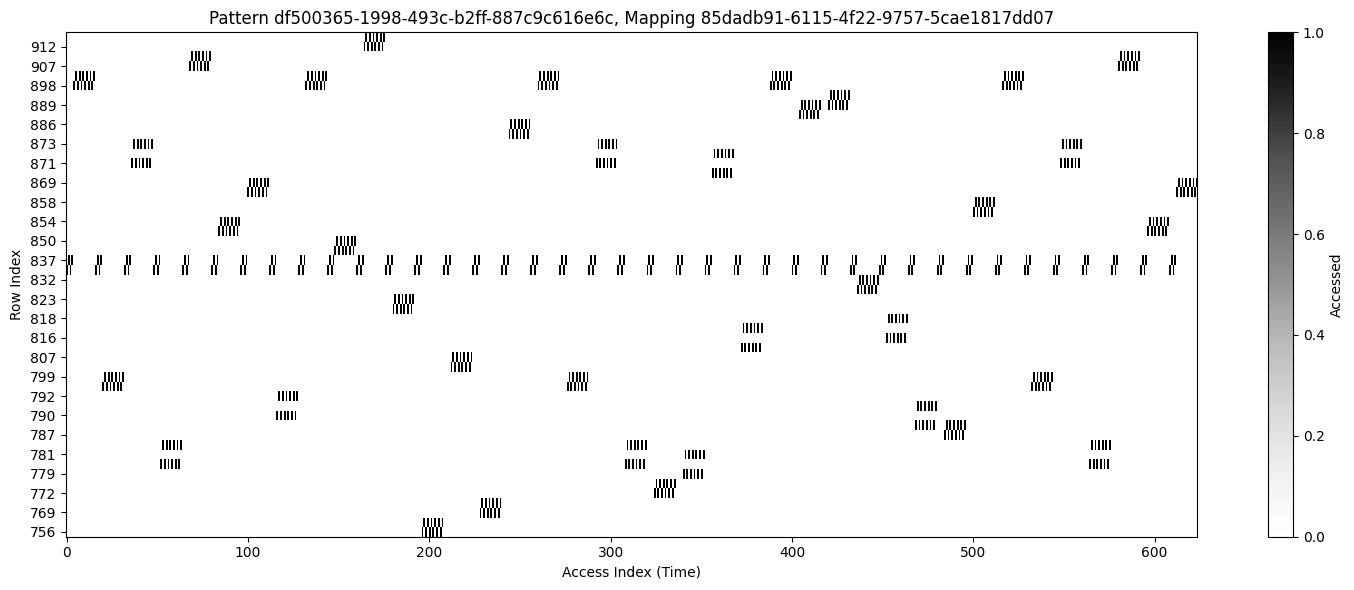

\begin{tikzpicture}
  \begin{axis}[
    xlabel={Access Index (Time)}, ylabel={Row Address},
    tick label style={font=\tiny},
    label style={font=\small},
    width=\textwidth, height=6cm,
    xtick distance=50,
    ytick={0,5,10,15,20,25,30,35,40,45,50},
    yticklabels={756,774,787,797,816,830,850,867,873,891,912},
    y dir=reverse,
    grid=both,
    scatter/use mapped color={draw=black,fill=black},
    only marks, mark=square*, mark size=1.5pt,
  ]
    \addplot table [x index=0, y index=1] {%
0 27
1 28
2 27
3 28
4 46
5 47
6 46
7 47
8 46
9 47
10 46
11 47
12 46
13 47
14 46
15 47
16 27
17 28
18 27
19 28
20 15
21 16
22 15
23 16
24 15
25 16
26 15
27 16
28 15
29 16
30 15
31 16
32 27
33 28
34 27
35 28
36 38
37 40
38 38
39 40
40 38
41 40
42 38
43 40
44 38
45 40
46 38
47 40
48 27
49 28
50 27
51 28
52 7
53 9
54 7
55 9
56 7
57 9
58 7
59 9
60 7
61 9
62 7
63 9
64 27
65 28
66 27
67 28
68 48
69 49
70 48
71 49
72 48
73 49
74 48
75 49
76 48
77 49
78 48
79 49
80 27
81 28
82 27
83 28
84 31
85 32


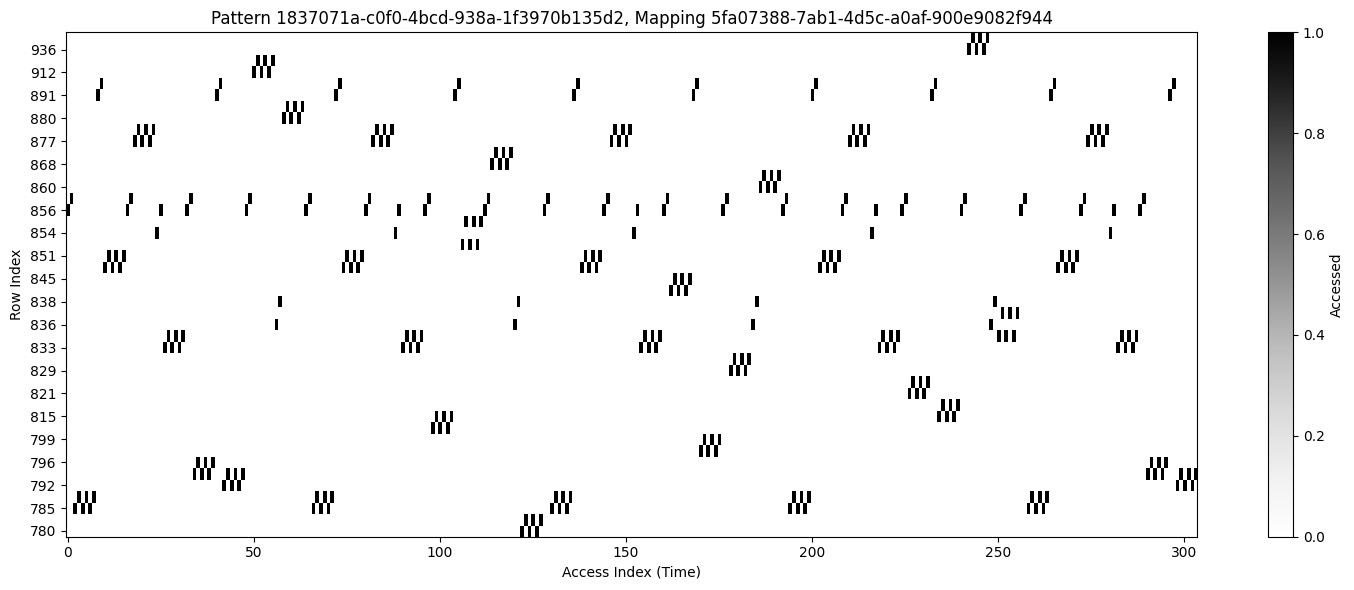

\begin{tikzpicture}
  \begin{axis}[
    xlabel={Access Index (Time)}, ylabel={Row Address},
    tick label style={font=\tiny},
    label style={font=\small},
    width=\textwidth, height=6cm,
    xtick distance=50,
    ytick={0,4,8,12,16,20,24,28,32,36,40},
    yticklabels={780,792,799,821,833,838,851,856,868,880,912},
    y dir=reverse,
    grid=both,
    scatter/use mapped color={draw=black,fill=black},
    only marks, mark=square*, mark size=1.5pt,
  ]
    \addplot table [x index=0, y index=1] {%
0 28
1 29
2 2
3 3
4 2
5 3
6 2
7 3
8 38
9 39
10 23
11 24
12 23
13 24
14 23
15 24
16 28
17 29
18 34
19 35
20 34
21 35
22 34
23 35
24 26
25 28
26 16
27 17
28 16
29 17
30 16
31 17
32 28
33 29
34 5
35 6
36 5
37 6
38 5
39 6
40 38
41 39
42 4
43 5
44 4
45 5
46 4
47 5
48 28
49 29
50 40
51 41
52 40
53 41
54 40
55 41
56 18
57 20
58 36
59 37
60 36
61 37
62 36
63 37
64 28
65 29
66 2
67 3
68 2
69 3
70 2
71 3
72 38
73 39
74 23
75 24
76 23
77 24
78 23
79 24
80 28
81 29
82 34
83 35
84 34
85 35
86 34
87 35
8

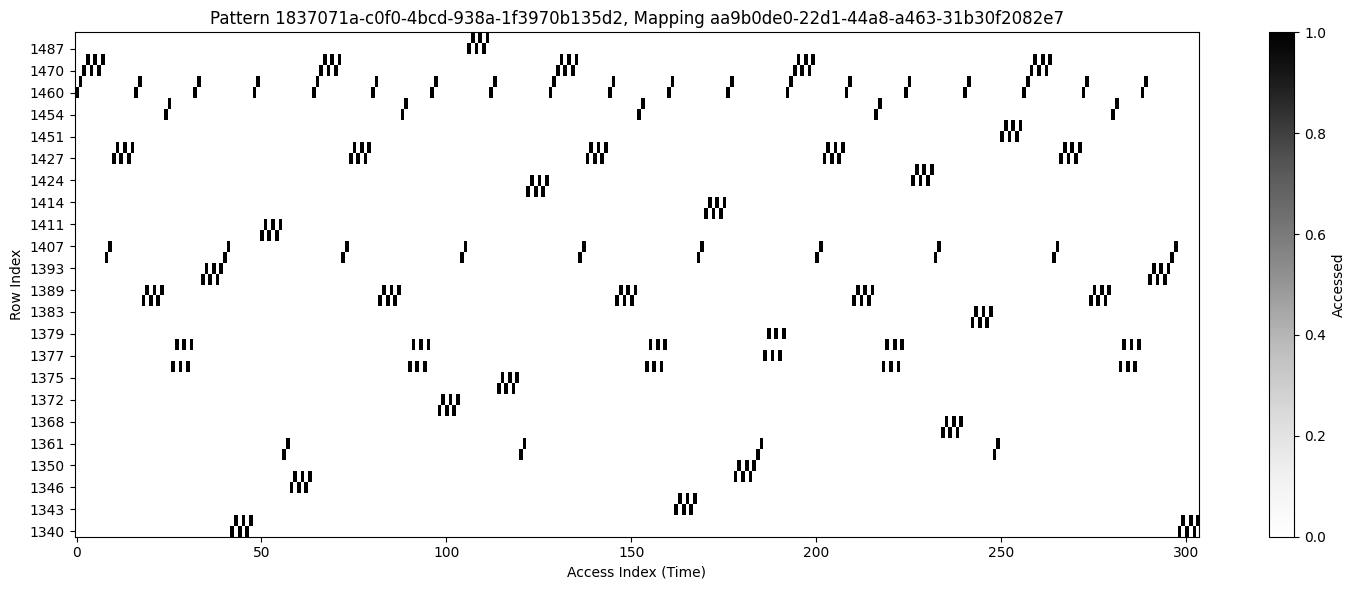

\begin{tikzpicture}
  \begin{axis}[
    xlabel={Access Index (Time)}, ylabel={Row Address},
    tick label style={font=\tiny},
    label style={font=\small},
    width=\textwidth, height=6cm,
    xtick distance=50,
    ytick={0,4,8,12,16,20,24,28,32,36,40,44},
    yticklabels={1340,1346,1361,1372,1377,1383,1393,1411,1424,1451,1460,1487},
    y dir=reverse,
    grid=both,
    scatter/use mapped color={draw=black,fill=black},
    only marks, mark=square*, mark size=1.5pt,
  ]
    \addplot table [x index=0, y index=1] {%
0 40
1 41
2 42
3 43
4 42
5 43
6 42
7 43
8 25
9 26
10 34
11 35
12 34
13 35
14 34
15 35
16 40
17 41
18 21
19 22
20 21
21 22
22 21
23 22
24 38
25 39
26 15
27 17
28 15
29 17
30 15
31 17
32 40
33 41
34 23
35 24
36 23
37 24
38 23
39 24
40 25
41 26
42 0
43 1
44 0
45 1
46 0
47 1
48 40
49 41
50 27
51 28
52 27
53 28
54 27
55 28
56 7
57 8
58 4
59 5
60 4
61 5
62 4
63 5
64 40
65 41
66 42
67 43
68 42
69 43
70 42
71 43
72 25
73 26
74 34
75 35
76 34
77 35
78 34
79 35
80 40
81 41
82 21
83

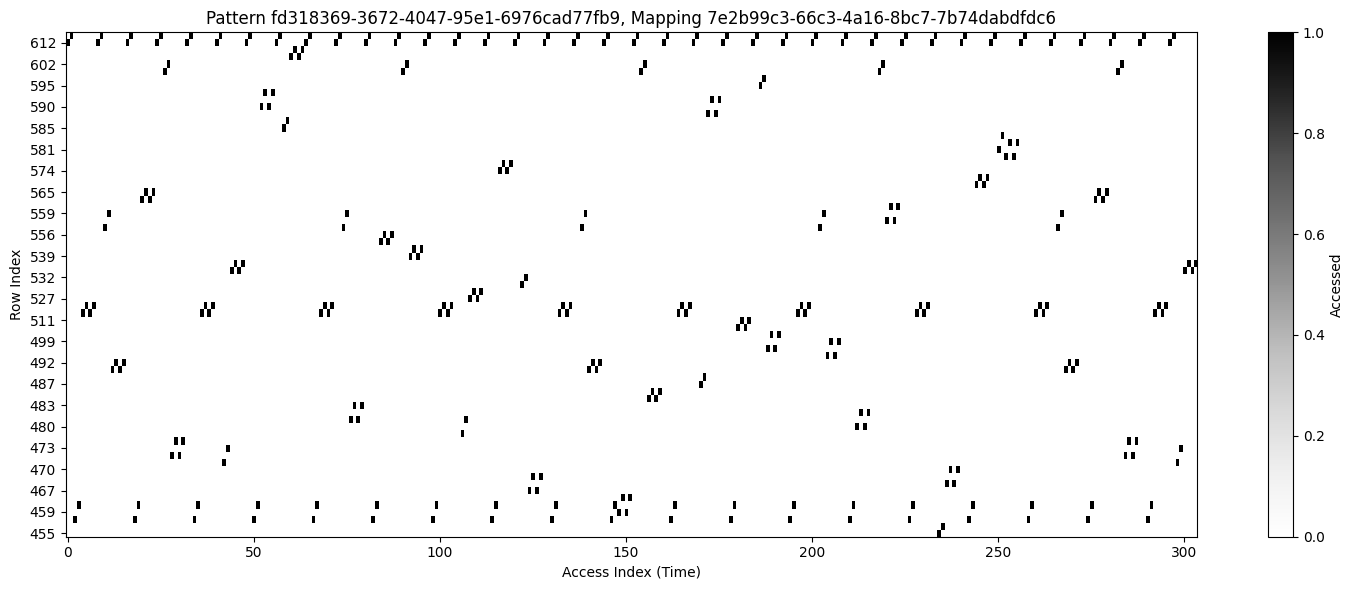

\begin{tikzpicture}
  \begin{axis}[
    xlabel={Access Index (Time)}, ylabel={Row Address},
    tick label style={font=\tiny},
    label style={font=\small},
    width=\textwidth, height=6cm,
    xtick distance=50,
    ytick={0,7,14,21,28,35,42,49,56,63,70},
    yticklabels={455,468,479,487,500,530,556,571,583,595,614},
    y dir=reverse,
    grid=both,
    scatter/use mapped color={draw=black,fill=black},
    only marks, mark=square*, mark size=1.5pt,
  ]
    \addplot table [x index=0, y index=1] {%
0 69
1 70
2 2
3 4
4 31
5 32
6 31
7 32
8 69
9 70
10 43
11 45
12 23
13 24
14 23
15 24
16 69
17 70
18 2
19 4
20 47
21 48
22 47
23 48
24 69
25 70
26 65
27 66
28 11
29 13
30 11
31 13
32 69
33 70
34 2
35 4
36 31
37 32
38 31
39 32
40 69
41 70
42 10
43 12
44 37
45 38
46 37
47 38
48 69
49 70
50 2
51 4
52 60
53 62
54 60
55 62
56 69
57 70
58 57
59 58
60 67
61 68
62 67
63 68
64 69
65 70
66 2
67 4
68 31
69 32
70 31
71 32
72 69
73 70
74 43
75 45
76 16
77 18
78 16
79 18
80 69
81 70
82 2
83 4
84 41
85 42


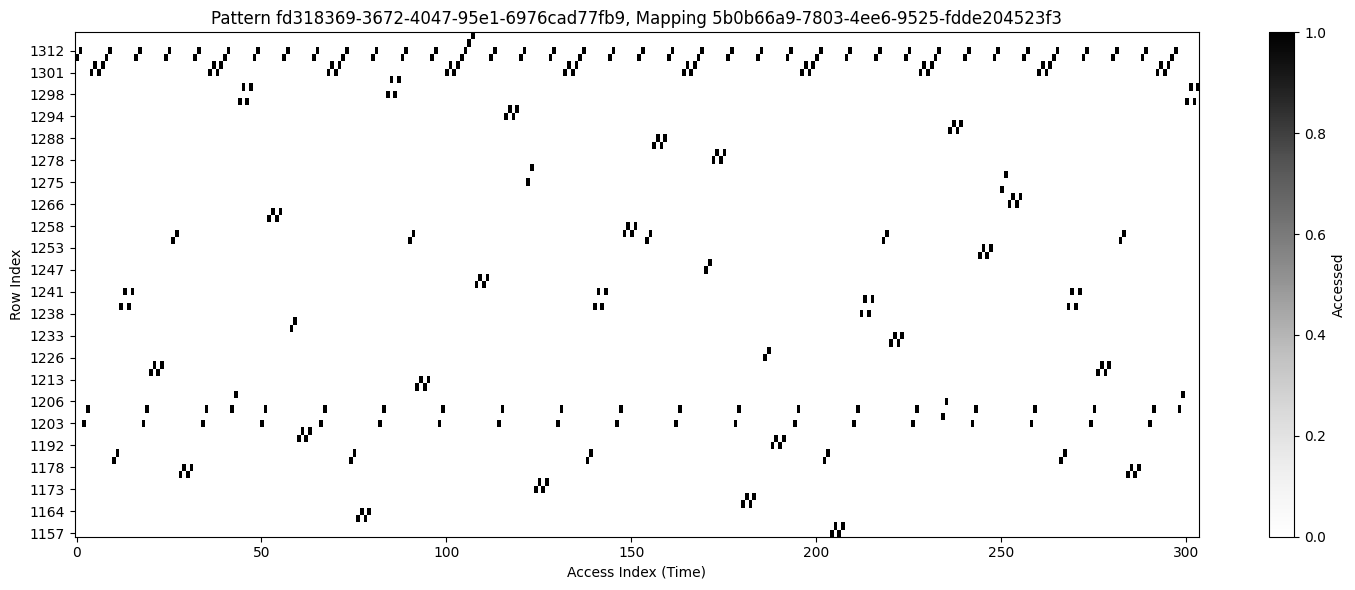

\begin{tikzpicture}
  \begin{axis}[
    xlabel={Access Index (Time)}, ylabel={Row Address},
    tick label style={font=\tiny},
    label style={font=\small},
    width=\textwidth, height=6cm,
    xtick distance=50,
    ytick={0,6,12,18,24,30,36,42,48,54,60,66},
    yticklabels={1157,1173,1192,1206,1226,1238,1247,1258,1275,1288,1298,1312},
    y dir=reverse,
    grid=both,
    scatter/use mapped color={draw=black,fill=black},
    only marks, mark=square*, mark size=1.5pt,
  ]
    \addplot table [x index=0, y index=1] {%
0 65
1 66
2 15
3 17
4 63
5 64
6 63
7 64
8 65
9 66
10 10
11 11
12 31
13 33
14 31
15 33
16 65
17 66
18 15
19 17
20 22
21 23
22 22
23 23
24 65
25 66
26 40
27 41
28 8
29 9
30 8
31 9
32 65
33 66
34 15
35 17
36 63
37 64
38 63
39 64
40 65
41 66
42 17
43 19
44 59
45 61
46 59
47 61
48 65
49 66
50 15
51 17
52 43
53 44
54 43
55 44
56 65
57 66
58 28
59 29
60 13
61 14
62 13
63 14
64 65
65 66
66 15
67 17
68 63
69 64
70 63
71 64
72 65
73 66
74 10
75 11
76 2
77 3
78 2
79 3
80 65
81 66
8

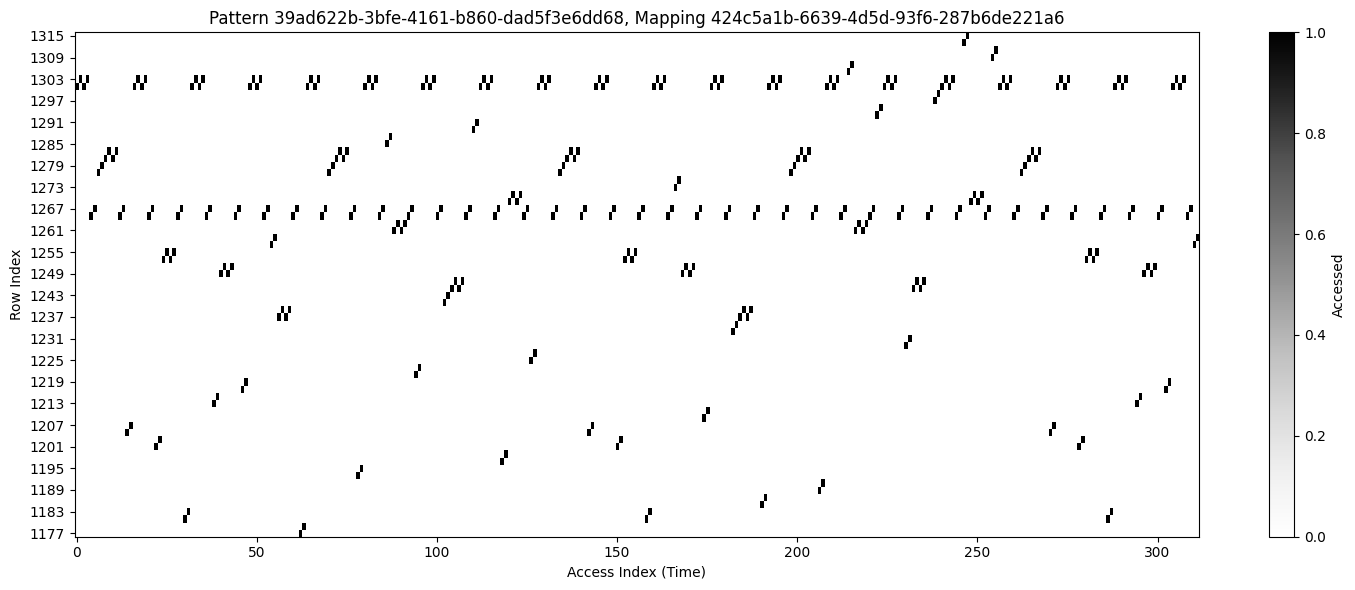

\begin{tikzpicture}
  \begin{axis}[
    xlabel={Access Index (Time)}, ylabel={Row Address},
    tick label style={font=\tiny},
    label style={font=\small},
    width=\textwidth, height=6cm,
    xtick distance=50,
    ytick={0,7,14,21,28,35,42,49,56,63},
    yticklabels={1177,1191,1205,1219,1233,1247,1261,1275,1289,1303},
    y dir=reverse,
    grid=both,
    scatter/use mapped color={draw=black,fill=black},
    only marks, mark=square*, mark size=1.5pt,
  ]
    \addplot table [x index=0, y index=1] {%
0 62
1 63
2 62
3 63
4 44
5 45
6 50
7 51
8 52
9 53
10 52
11 53
12 44
13 45
14 14
15 15
16 62
17 63
18 62
19 63
20 44
21 45
22 12
23 13
24 38
25 39
26 38
27 39
28 44
29 45
30 2
31 3
32 62
33 63
34 62
35 63
36 44
37 45
38 18
39 19
40 36
41 37
42 36
43 37
44 44
45 45
46 20
47 21
48 62
49 63
50 62
51 63
52 44
53 45
54 40
55 41
56 30
57 31
58 30
59 31
60 44
61 45
62 0
63 1
64 62
65 63
66 62
67 63
68 44
69 45
70 50
71 51
72 52
73 53
74 52
75 53
76 44
77 45
78 8
79 9
80 62
81 63
82 62
83 63
84 

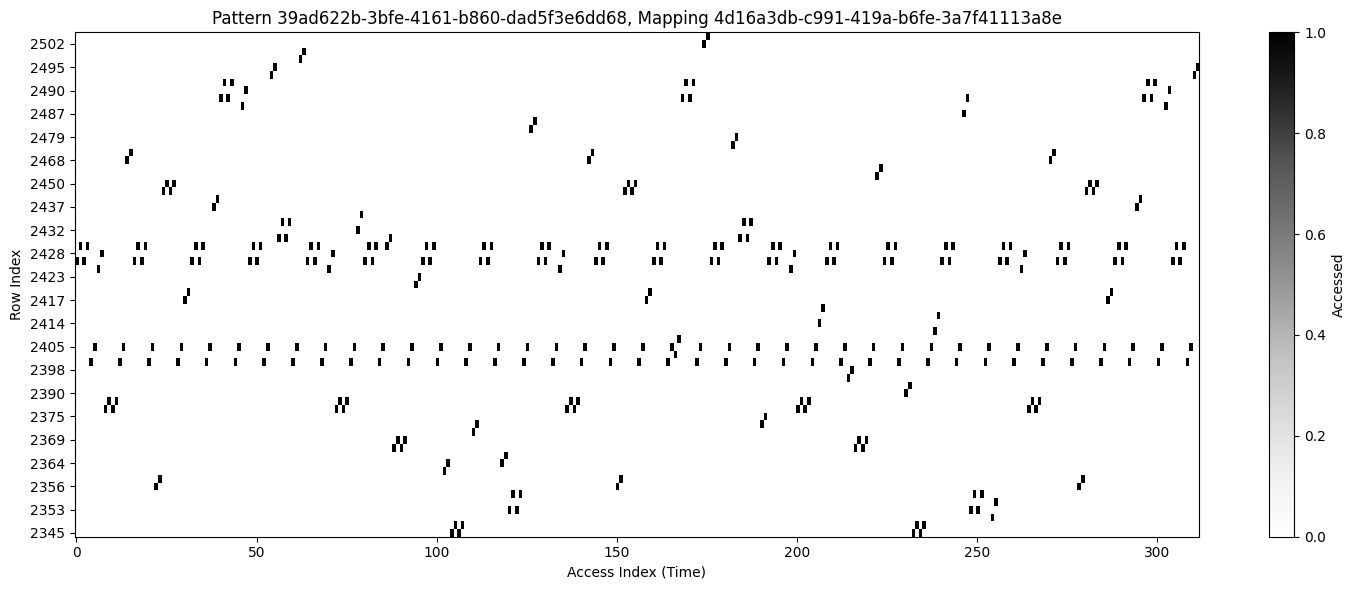

\begin{tikzpicture}
  \begin{axis}[
    xlabel={Access Index (Time)}, ylabel={Row Address},
    tick label style={font=\tiny},
    label style={font=\small},
    width=\textwidth, height=6cm,
    xtick distance=50,
    ytick={0,6,12,18,24,30,36,42,48,54,60},
    yticklabels={2345,2356,2369,2390,2405,2417,2428,2437,2468,2487,2495},
    y dir=reverse,
    grid=both,
    scatter/use mapped color={draw=black,fill=black},
    only marks, mark=square*, mark size=1.5pt,
  ]
    \addplot table [x index=0, y index=1] {%
0 35
1 37
2 35
3 37
4 22
5 24
6 34
7 36
8 16
9 17
10 16
11 17
12 22
13 24
14 48
15 49
16 35
17 37
18 35
19 37
20 22
21 24
22 6
23 7
24 44
25 45
26 44
27 45
28 22
29 24
30 30
31 31
32 35
33 37
34 35
35 37
36 22
37 24
38 42
39 43
40 56
41 58
42 56
43 58
44 22
45 24
46 55
47 57
48 35
49 37
50 35
51 37
52 22
53 24
54 59
55 60
56 38
57 40
58 38
59 40
60 22
61 24
62 61
63 62
64 35
65 37
66 35
67 37
68 22
69 24
70 34
71 36
72 16
73 17
74 16
75 17
76 22
77 24
78 39
79 41
80 35
81 37
82 

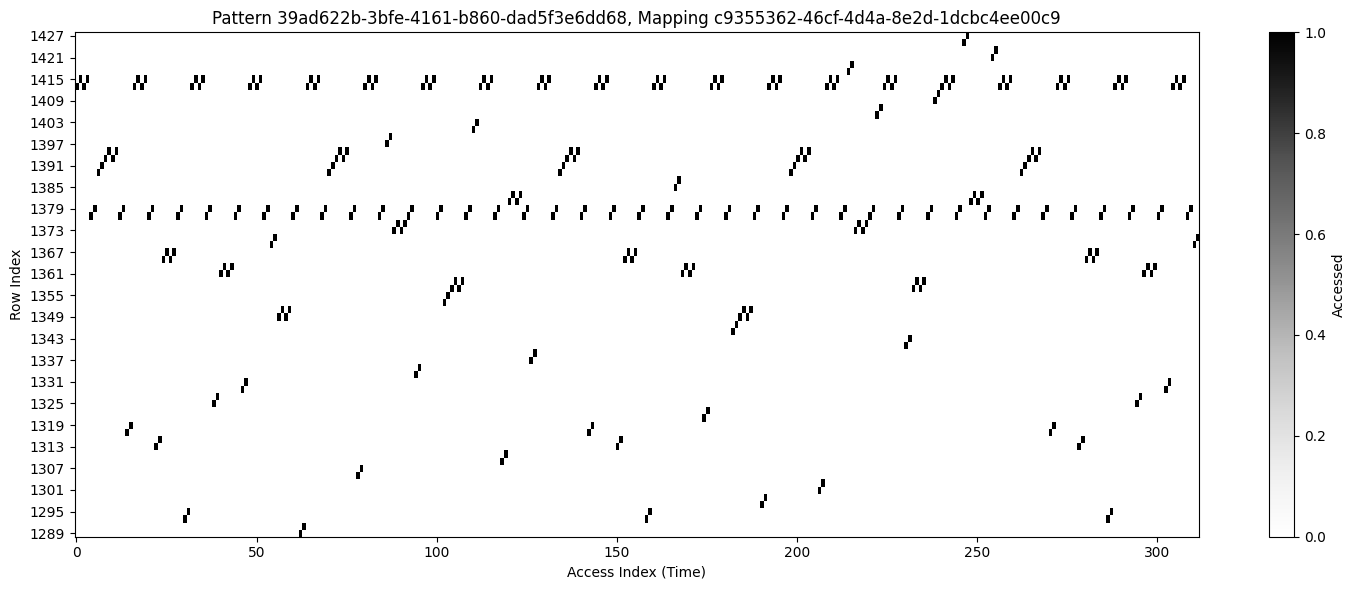

\begin{tikzpicture}
  \begin{axis}[
    xlabel={Access Index (Time)}, ylabel={Row Address},
    tick label style={font=\tiny},
    label style={font=\small},
    width=\textwidth, height=6cm,
    xtick distance=50,
    ytick={0,7,14,21,28,35,42,49,56,63},
    yticklabels={1289,1303,1317,1331,1345,1359,1373,1387,1401,1415},
    y dir=reverse,
    grid=both,
    scatter/use mapped color={draw=black,fill=black},
    only marks, mark=square*, mark size=1.5pt,
  ]
    \addplot table [x index=0, y index=1] {%
0 62
1 63
2 62
3 63
4 44
5 45
6 50
7 51
8 52
9 53
10 52
11 53
12 44
13 45
14 14
15 15
16 62
17 63
18 62
19 63
20 44
21 45
22 12
23 13
24 38
25 39
26 38
27 39
28 44
29 45
30 2
31 3
32 62
33 63
34 62
35 63
36 44
37 45
38 18
39 19
40 36
41 37
42 36
43 37
44 44
45 45
46 20
47 21
48 62
49 63
50 62
51 63
52 44
53 45
54 40
55 41
56 30
57 31
58 30
59 31
60 44
61 45
62 0
63 1
64 62
65 63
66 62
67 63
68 44
69 45
70 50
71 51
72 52
73 53
74 52
75 53
76 44
77 45
78 8
79 9
80 62
81 63
82 62
83 63
84 

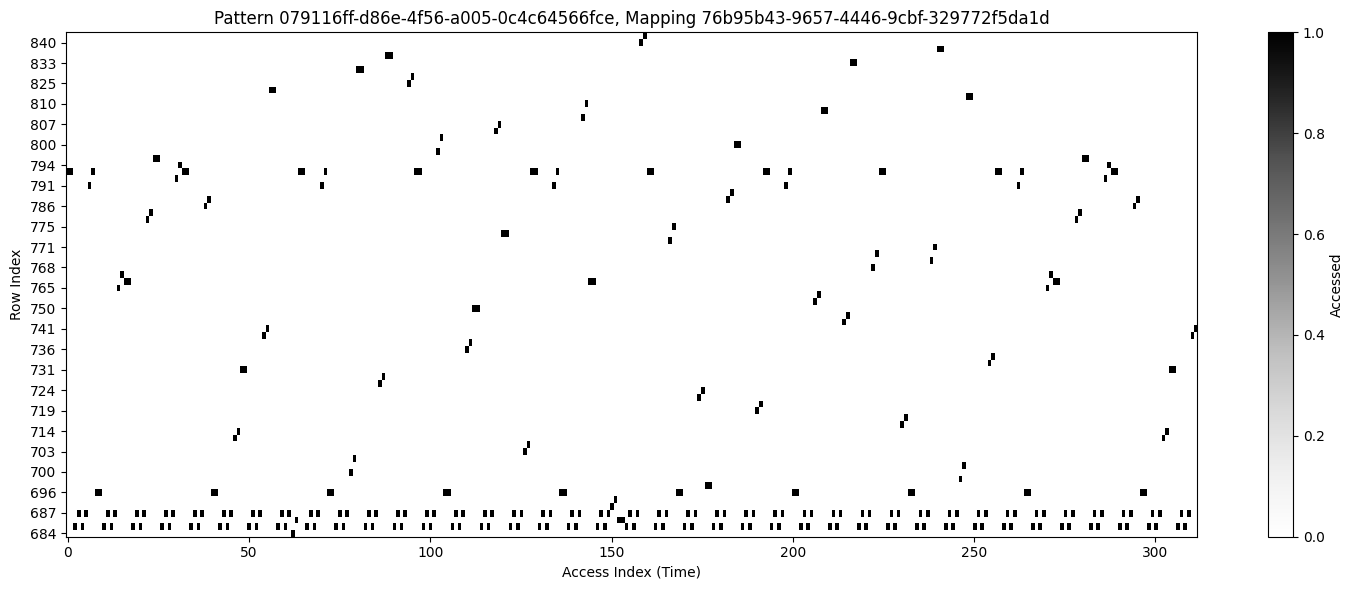

\begin{tikzpicture}
  \begin{axis}[
    xlabel={Access Index (Time)}, ylabel={Row Address},
    tick label style={font=\tiny},
    label style={font=\small},
    width=\textwidth, height=6cm,
    xtick distance=50,
    ytick={0,7,14,21,28,35,42,49,56,63,70},
    yticklabels={684,697,712,724,738,755,771,788,799,810,836},
    y dir=reverse,
    grid=both,
    scatter/use mapped color={draw=black,fill=black},
    only marks, mark=square*, mark size=1.5pt,
  ]
    \addplot table [x index=0, y index=1] {%
0 53
1 53
2 1
3 3
4 1
5 3
6 51
7 53
8 6
9 6
10 1
11 3
12 1
13 3
14 36
15 38
16 37
17 37
18 1
19 3
20 1
21 3
22 46
23 47
24 55
25 55
26 1
27 3
28 1
29 3
30 52
31 54
32 53
33 53
34 1
35 3
36 1
37 3
38 48
39 49
40 6
41 6
42 1
43 3
44 1
45 3
46 14
47 15
48 24
49 24
50 1
51 3
52 1
53 3
54 29
55 30
56 65
57 65
58 1
59 3
60 1
61 3
62 0
63 2
64 53
65 53
66 1
67 3
68 1
69 3
70 51
71 53
72 6
73 6
74 1
75 3
76 1
77 3
78 9
79 11
80 68
81 68
82 1
83 3
84 1
85 3
86 22
87 23
88 70
89 70
90 1
91 3
92 1
93

In [31]:
import json

# Load the JSON data from the file
with open('../config/fuzz-summary.json', 'r') as f:
    data = json.load(f)

# Extract relevant parts
for hammering_pattern in data["hammering_patterns"]:
    for address_mapping in hammering_pattern["address_mappings"]:
        # Plot
        plot_hammering_grid(hammering_pattern, address_mapping, f"Pattern {hammering_pattern['id']}, Mapping {address_mapping['id']}")
        print(generate_pgfplots_scatter(hammering_pattern, address_mapping))